# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Attack','is_Normal']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)

    y_train = y_output.values
    y_test = y_test.values

    x_train = np.hstack((x_train, y_train))
    x_test = np.hstack((x_test, np.random.normal(size = (x_test.shape[0], y_train.shape[1]))))
    #x_test = np.hstack((x_test, y_test))
    
preprocess.x_train.std()

0.99186991653217393

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 124
    classes = 2
    hidden_encoder_dim = 124
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 124
    lam = 0.01
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), mean=0, stddev=1, name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            
            #tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Reconstruction"):
            self.x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = None)
            
            self.y = tf.slice(self.x_hat, [0,input_dim-2], [-1,-1])

        with tf.variable_scope("Loss"):
            
            BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.x_hat, labels=self.x), reduction_indices=1)
            KLD = -0.5 * tf.reduce_mean(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder), reduction_indices=1)
            softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            loss = tf.reduce_mean((BCE + KLD + softmax_loss) * lam)

            #loss = tf.clip_by_value(loss, -1e-2, 1e-2)
            #loss = tf.where(tf.is_nan(loss), 1e-2, loss)
            #loss = tf.where(tf.equal(loss, -1e-2), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-2), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = tf.abs(loss, name = "Regularized_loss")
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=1e-2
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score'])

    predictions = {}

    results = []
    best_acc = 0
    
    def train(epochs, net, h,f):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            
            for epoch in range(1, (epochs+1)):
                #print("Step {} | Training Loss:".format(epoch), end = " " )
                x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                          preprocess.y_train, 
                                                                          test_size=0.1)
                batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                           batch_iterations)
                                                                          
                for i in batch_indices:
                    
                    def train_batch():
                        nonlocal train_loss
                        _, train_loss = sess.run([net.train_op, 
                                                   net.regularized_loss, 
                                                   ], #net.summary_op
                                                  feed_dict={net.x: x_train[i,:], 
                                                             net.y_: y_train[i,:], 
                                                             net.keep_prob:1})
                    train_batch()
                        
                    count = 10
                    if((train_loss > 1e4 or np.isnan(train_loss)) and epoch > 1 and count < 1):
                        print("Step {} | High Training Loss: {:.6f} ... Restoring Net".format(epoch, train_loss))
                        net.saver.restore(sess, 
                                          tf.train.latest_checkpoint('dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_{}_features count_{}'
                                                                     .format(epochs,h,f)))
                        train_batch()
                        count -=1
                    
                    #summary_writer_train.add_summary(summary_str, epoch)
                    #if(train_loss > 1e9):
                    
                    #print("{:.6f}".format(train_loss), end = ", " )
                    
                #print("")
                valid_loss, valid_accuracy = sess.run([net.regularized_loss, net.tf_accuracy], feed_dict={net.x: x_valid, 
                                                                     net.y_: y_valid, 
                                                                     net.keep_prob:1})
                    
                
                accuracy, test_loss, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, net.regularized_loss, 
                                                               net.pred, 
                                                               net.actual, net.y], 
                                                              feed_dict={net.x: preprocess.x_test, 
                                                                         net.y_: preprocess.y_test, 
                                                                         net.keep_prob:1})
                #print("*************** \n")
                print("Step {} | Training Loss: {:.6f} | Test Loss: {:6f} | Test Accuracy: {:.6f}".format(epoch, train_loss, test_loss, accuracy))
                #print("*************** \n")
                #print("Accuracy on Test data: {}".format(accuracy))

                

                if accuracy > Train.best_acc:
                    Train.best_acc = accuracy
                    Train.pred_value = pred_value
                    Train.actual_value = actual_value
                    Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)
                   
                    #net.saver.save(sess, "dataset/tf_vae_only_vae_loss_nsl_kdd_hidden layers_{}_features count_{}".format(epochs,h,f))
                    #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))
                    #curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1]})
                    #Train.predictions.update({"{}_{}_{}".format(epochs,f,h):curr_pred})
                    
                    if(not np.isnan(train_loss)):
                        net.saver.save(sess, 
                                   "dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_{}_features count_{}/model"
                                   .format(epochs,h,f), 
                                   global_step = epoch, 
                                   write_meta_graph=False)
                    
                    curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value})
                    Train.predictions.update({"{}_{}_{}".format(epochs,f,h):
                                              (curr_pred, 
                                               Train.result(epochs, f, h,valid_accuracy, accuracy))})
            
            

In [9]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]
    features_arr = [4, 8, 16, 32]
    hidden_layers_arr = [2, 4, 6]

    epochs = [100]
    
    for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
        print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
        n = network(2,h,f)
        n.build_layers()
        Train.train(e, n, h,f)
        

Current Layer Attributes - epochs:100 hidden layers:2 features count:4
Step 1 | Training Loss: 0.000029 | Test Loss: 0.004157 | Test Accuracy: 0.850603
Step 2 | High Training Loss: 426683648.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_100_features count_2/model-1
Step 2 | Training Loss: 0.000097 | Test Loss: 0.003621 | Test Accuracy: 0.822170
Step 3 | Training Loss: 0.000969 | Test Loss: 0.004888 | Test Accuracy: 0.781583
Step 4 | Training Loss: 0.000050 | Test Loss: 0.009014 | Test Accuracy: 0.724716
Step 5 | Training Loss: 0.000123 | Test Loss: 0.005009 | Test Accuracy: 0.759182
Step 6 | Training Loss: 0.000057 | Test Loss: 0.004406 | Test Accuracy: 0.789922
Step 7 | Training Loss: 0.000495 | Test Loss: 0.004475 | Test Accuracy: 0.778345
Step 8 | Training Loss: 0.000015 | Test Loss: 0.005325 | Test Accuracy: 0.777103
Step 9 | Training Loss: 0.001799 | Test Loss: 0.006058 | Test Accuracy: 0.790099
Step 10 | Trai

Step 98 | Training Loss: 0.000083 | Test Loss: 0.007431 | Test Accuracy: 0.772622
Step 99 | Training Loss: 0.000098 | Test Loss: 0.007736 | Test Accuracy: 0.782559
Step 100 | Training Loss: 0.000339 | Test Loss: 0.006728 | Test Accuracy: 0.771780
Current Layer Attributes - epochs:100 hidden layers:2 features count:8
Step 1 | Training Loss: 0.000129 | Test Loss: 0.006415 | Test Accuracy: 0.801943
Step 2 | Training Loss: 0.000254 | Test Loss: 0.006246 | Test Accuracy: 0.789301
Step 3 | Training Loss: 0.000255 | Test Loss: 0.006203 | Test Accuracy: 0.767033
Step 4 | Training Loss: 0.000583 | Test Loss: 0.007496 | Test Accuracy: 0.741439
Step 5 | Training Loss: 0.000198 | Test Loss: 0.009102 | Test Accuracy: 0.704179
Step 6 | Training Loss: 0.000341 | Test Loss: 0.009360 | Test Accuracy: 0.706707
Step 7 | Training Loss: 0.000337 | Test Loss: 0.010575 | Test Accuracy: 0.723918
Step 8 | Training Loss: 0.000757 | Test Loss: 0.010775 | Test Accuracy: 0.715845
Step 9 | Training Loss: 0.000479 |

Step 98 | Training Loss: 0.000016 | Test Loss: 0.010410 | Test Accuracy: 0.722409
Step 99 | Training Loss: 0.000061 | Test Loss: 0.012098 | Test Accuracy: 0.694553
Step 100 | Training Loss: 0.000084 | Test Loss: 0.011498 | Test Accuracy: 0.710477
Current Layer Attributes - epochs:100 hidden layers:2 features count:16
Step 1 | Training Loss: 0.001756 | Test Loss: 0.006645 | Test Accuracy: 0.842708
Step 2 | Training Loss: 0.000356 | Test Loss: 0.006969 | Test Accuracy: 0.777457
Step 3 | Training Loss: 0.000049 | Test Loss: 0.008161 | Test Accuracy: 0.767920
Step 4 | Training Loss: 0.000066 | Test Loss: 0.008296 | Test Accuracy: 0.778522
Step 5 | Training Loss: 0.000811 | Test Loss: 0.008021 | Test Accuracy: 0.751553
Step 6 | High Training Loss: 1148301.375000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_100_features count_2/model-1
Step 6 | Training Loss: 0.001307 | Test Loss: 0.008833 | Test Accuracy: 0.743790
Step 7 | Tr

Step 79 | Training Loss: 0.000404 | Test Loss: 0.012624 | Test Accuracy: 0.678185
Step 80 | Training Loss: 0.000348 | Test Loss: 0.015252 | Test Accuracy: 0.702848
Step 81 | Training Loss: 0.000057 | Test Loss: 0.015139 | Test Accuracy: 0.673439
Step 82 | Training Loss: 0.000470 | Test Loss: 0.012724 | Test Accuracy: 0.690428
Step 83 | Training Loss: 0.000307 | Test Loss: 0.015267 | Test Accuracy: 0.676632
Step 84 | Training Loss: 0.000076 | Test Loss: 0.014608 | Test Accuracy: 0.715091
Step 85 | Training Loss: 0.000258 | Test Loss: 0.012428 | Test Accuracy: 0.709191
Step 86 | Training Loss: 0.000229 | Test Loss: 0.016424 | Test Accuracy: 0.706441
Step 87 | Training Loss: 0.000107 | Test Loss: 0.010845 | Test Accuracy: 0.713982
Step 88 | Training Loss: 0.000210 | Test Loss: 0.012516 | Test Accuracy: 0.732390
Step 89 | Training Loss: 0.000123 | Test Loss: 0.011965 | Test Accuracy: 0.692823
Step 90 | Training Loss: 0.000325 | Test Loss: 0.011806 | Test Accuracy: 0.695751
Step 91 | Traini

Step 67 | Training Loss: 0.000367 | Test Loss: 0.023989 | Test Accuracy: 0.706219
Step 68 | Training Loss: 0.000399 | Test Loss: 0.025328 | Test Accuracy: 0.654631
Step 69 | Training Loss: 0.000226 | Test Loss: 0.017690 | Test Accuracy: 0.699876
Step 70 | Training Loss: 0.000156 | Test Loss: 0.013391 | Test Accuracy: 0.723873
Step 71 | Training Loss: 0.000582 | Test Loss: 0.019225 | Test Accuracy: 0.692823
Step 72 | Training Loss: 0.000202 | Test Loss: 0.016658 | Test Accuracy: 0.691625
Step 73 | Training Loss: 0.000046 | Test Loss: 0.020241 | Test Accuracy: 0.688964
Step 74 | Training Loss: 0.000369 | Test Loss: 0.021025 | Test Accuracy: 0.638086
Step 75 | Training Loss: 0.000050 | Test Loss: 0.020906 | Test Accuracy: 0.660752
Step 76 | Training Loss: 0.000277 | Test Loss: 0.015176 | Test Accuracy: 0.691847
Step 77 | Training Loss: 0.000064 | Test Loss: 0.015956 | Test Accuracy: 0.674281
Step 78 | Training Loss: 0.000037 | Test Loss: 0.019077 | Test Accuracy: 0.674193
Step 79 | Traini

Step 62 | Training Loss: 0.000681 | Test Loss: 0.003768 | Test Accuracy: 0.861293
Step 63 | Training Loss: 0.000034 | Test Loss: 0.003476 | Test Accuracy: 0.847409
Step 64 | Training Loss: 0.000223 | Test Loss: 0.003939 | Test Accuracy: 0.845546
Step 65 | Training Loss: 0.000314 | Test Loss: 0.003721 | Test Accuracy: 0.854019
Step 66 | Training Loss: 0.000689 | Test Loss: 0.003472 | Test Accuracy: 0.862491
Step 67 | Training Loss: 0.000026 | Test Loss: 0.002771 | Test Accuracy: 0.861781
Step 68 | Training Loss: 0.000547 | Test Loss: 0.003849 | Test Accuracy: 0.858144
Step 69 | Training Loss: 0.000137 | Test Loss: 0.003102 | Test Accuracy: 0.848119
Step 70 | Training Loss: 0.000497 | Test Loss: 0.002971 | Test Accuracy: 0.866971
Step 71 | Training Loss: 0.000097 | Test Loss: 0.003196 | Test Accuracy: 0.850515
Step 72 | Training Loss: 0.000007 | Test Loss: 0.003628 | Test Accuracy: 0.850293
Step 73 | Training Loss: 0.000175 | Test Loss: 0.004829 | Test Accuracy: 0.835300
Step 74 | Traini

Step 59 | Training Loss: 0.000392 | Test Loss: 0.003272 | Test Accuracy: 0.825541
Step 60 | Training Loss: 0.000158 | Test Loss: 0.003580 | Test Accuracy: 0.826828
Step 61 | Training Loss: 0.000088 | Test Loss: 0.003526 | Test Accuracy: 0.824965
Step 62 | Training Loss: 0.000681 | Test Loss: 0.003604 | Test Accuracy: 0.810238
Step 63 | Training Loss: 0.000052 | Test Loss: 0.005377 | Test Accuracy: 0.810593
Step 64 | Training Loss: 0.000351 | Test Loss: 0.003896 | Test Accuracy: 0.814718
Step 65 | Training Loss: 0.000092 | Test Loss: 0.003171 | Test Accuracy: 0.819597
Step 66 | Training Loss: 0.000101 | Test Loss: 0.003046 | Test Accuracy: 0.832106
Step 67 | Training Loss: 0.000082 | Test Loss: 0.003541 | Test Accuracy: 0.832683
Step 68 | Training Loss: 0.000005 | Test Loss: 0.003390 | Test Accuracy: 0.832771
Step 69 | Training Loss: 0.000103 | Test Loss: 0.003502 | Test Accuracy: 0.833126
Step 70 | Training Loss: 0.000089 | Test Loss: 0.005328 | Test Accuracy: 0.825408
Step 71 | Traini

Step 59 | Training Loss: 0.000024 | Test Loss: 0.004146 | Test Accuracy: 0.805846
Step 60 | Training Loss: 0.000237 | Test Loss: 0.003630 | Test Accuracy: 0.804915
Step 61 | Training Loss: 0.000314 | Test Loss: 0.003560 | Test Accuracy: 0.820928
Step 62 | Training Loss: 0.000271 | Test Loss: 0.003062 | Test Accuracy: 0.821948
Step 63 | Training Loss: 0.000560 | Test Loss: 0.002644 | Test Accuracy: 0.824210
Step 64 | Training Loss: 0.000427 | Test Loss: 0.003169 | Test Accuracy: 0.823634
Step 65 | Training Loss: 0.000287 | Test Loss: 0.002807 | Test Accuracy: 0.821105
Step 66 | Training Loss: 0.000308 | Test Loss: 0.002402 | Test Accuracy: 0.821194
Step 67 | Training Loss: 0.000425 | Test Loss: 0.003560 | Test Accuracy: 0.808197
Step 68 | Training Loss: 0.000628 | Test Loss: 0.002909 | Test Accuracy: 0.820928
Step 69 | Training Loss: 0.000117 | Test Loss: 0.002878 | Test Accuracy: 0.822880
Step 70 | Training Loss: 0.000049 | Test Loss: 0.002659 | Test Accuracy: 0.823412
Step 71 | Traini

Step 54 | Training Loss: 0.000317 | Test Loss: 0.004580 | Test Accuracy: 0.551056
Step 55 | Training Loss: 0.000005 | Test Loss: 0.003419 | Test Accuracy: 0.431068
Step 56 | Training Loss: 0.001575 | Test Loss: 0.007586 | Test Accuracy: 0.572614
Step 57 | Training Loss: 0.000411 | Test Loss: 0.005544 | Test Accuracy: 0.430713
Step 58 | Training Loss: 0.001240 | Test Loss: 0.005102 | Test Accuracy: 0.430758
Step 59 | Training Loss: 0.004981 | Test Loss: 0.004813 | Test Accuracy: 0.430758
Step 60 | Training Loss: 0.000625 | Test Loss: 0.005019 | Test Accuracy: 0.431334
Step 61 | Training Loss: 0.003332 | Test Loss: 0.006996 | Test Accuracy: 0.430758
Step 62 | Training Loss: 0.001024 | Test Loss: 0.003649 | Test Accuracy: 0.430536
Step 63 | Training Loss: 0.001717 | Test Loss: 0.005405 | Test Accuracy: 0.430802
Step 64 | Training Loss: 0.000576 | Test Loss: 0.004467 | Test Accuracy: 0.431822
Step 65 | Training Loss: 0.000556 | Test Loss: 0.004192 | Test Accuracy: 0.564186
Step 66 | Traini

Step 49 | Training Loss: 0.000617 | Test Loss: 0.003921 | Test Accuracy: 0.437056
Step 50 | Training Loss: 0.000336 | Test Loss: 0.002754 | Test Accuracy: 0.569242
Step 51 | Training Loss: 0.002588 | Test Loss: 0.003857 | Test Accuracy: 0.430758
Step 52 | Training Loss: 0.000685 | Test Loss: 0.003165 | Test Accuracy: 0.561435
Step 53 | Training Loss: 0.000590 | Test Loss: 0.004722 | Test Accuracy: 0.439141
Step 54 | Training Loss: 0.002545 | Test Loss: 0.003276 | Test Accuracy: 0.569242
Step 55 | Training Loss: 0.000176 | Test Loss: 0.003168 | Test Accuracy: 0.438121
Step 56 | Training Loss: 0.000708 | Test Loss: 0.003333 | Test Accuracy: 0.569242
Step 57 | Training Loss: 0.000388 | Test Loss: 0.002509 | Test Accuracy: 0.561790
Step 58 | Training Loss: 0.006593 | Test Loss: 0.007436 | Test Accuracy: 0.430758
Step 59 | Training Loss: 0.007599 | Test Loss: 0.008609 | Test Accuracy: 0.430758
Step 60 | Training Loss: 0.007185 | Test Loss: 0.009156 | Test Accuracy: 0.430758
Step 61 | Traini

Step 49 | Training Loss: 0.000321 | Test Loss: 0.001645 | Test Accuracy: 0.418382
Step 50 | Training Loss: 0.001403 | Test Loss: 0.005054 | Test Accuracy: 0.430758
Step 51 | Training Loss: 0.000034 | Test Loss: 0.002091 | Test Accuracy: 0.582417
Step 52 | Training Loss: 0.000680 | Test Loss: 0.001869 | Test Accuracy: 0.430758
Step 53 | Training Loss: 0.000025 | Test Loss: 0.002239 | Test Accuracy: 0.430758
Step 54 | Training Loss: 0.000353 | Test Loss: 0.003882 | Test Accuracy: 0.430758
Step 55 | Training Loss: 0.000413 | Test Loss: 0.002523 | Test Accuracy: 0.582727
Step 56 | Training Loss: 0.001188 | Test Loss: 0.002016 | Test Accuracy: 0.583126
Step 57 | Training Loss: 0.000268 | Test Loss: 0.002862 | Test Accuracy: 0.430935
Step 58 | Training Loss: 0.000254 | Test Loss: 0.002587 | Test Accuracy: 0.582771
Step 59 | Training Loss: 0.000191 | Test Loss: 0.002430 | Test Accuracy: 0.431423
Step 60 | Training Loss: 0.000312 | Test Loss: 0.002889 | Test Accuracy: 0.582461
Step 61 | Traini

Step 42 | Training Loss: 0.017970 | Test Loss: 0.019258 | Test Accuracy: 0.430713
Step 43 | Training Loss: 0.005705 | Test Loss: 0.017922 | Test Accuracy: 0.430802
Step 44 | Training Loss: 0.005612 | Test Loss: 0.017457 | Test Accuracy: 0.430802
Step 45 | Training Loss: 0.007294 | Test Loss: 0.015981 | Test Accuracy: 0.430758
Step 46 | Training Loss: 0.005546 | Test Loss: 0.016307 | Test Accuracy: 0.430758
Step 47 | Training Loss: 0.010055 | Test Loss: 0.017367 | Test Accuracy: 0.569242
Step 48 | Training Loss: 0.007996 | Test Loss: 0.016084 | Test Accuracy: 0.430758
Step 49 | Training Loss: 0.006539 | Test Loss: 0.014602 | Test Accuracy: 0.430758
Step 50 | Training Loss: 0.007242 | Test Loss: 0.014112 | Test Accuracy: 0.430758
Step 51 | Training Loss: 0.007244 | Test Loss: 0.013548 | Test Accuracy: 0.430713
Step 52 | Training Loss: 0.008703 | Test Loss: 0.013769 | Test Accuracy: 0.430758
Step 53 | Training Loss: 0.006125 | Test Loss: 0.012907 | Test Accuracy: 0.430802
Step 54 | Traini

Step 42 | Training Loss: 0.000374 | Test Loss: 0.005003 | Test Accuracy: 0.753416
Step 43 | Training Loss: 0.000396 | Test Loss: 0.005497 | Test Accuracy: 0.756254
Step 44 | Training Loss: 0.000015 | Test Loss: 0.005348 | Test Accuracy: 0.763440
Step 45 | Training Loss: 0.000581 | Test Loss: 0.005155 | Test Accuracy: 0.750355
Step 46 | Training Loss: 0.000287 | Test Loss: 0.005958 | Test Accuracy: 0.752395
Step 47 | Training Loss: 0.000033 | Test Loss: 0.005571 | Test Accuracy: 0.775861
Step 48 | Training Loss: 0.000450 | Test Loss: 0.006338 | Test Accuracy: 0.750887
Step 49 | Training Loss: 0.000286 | Test Loss: 0.003786 | Test Accuracy: 0.832727
Step 50 | Training Loss: 0.000219 | Test Loss: 0.003433 | Test Accuracy: 0.830376
Step 51 | Training Loss: 0.000161 | Test Loss: 0.003079 | Test Accuracy: 0.860894
Step 52 | Training Loss: 0.000492 | Test Loss: 0.002996 | Test Accuracy: 0.854418
Step 53 | Training Loss: 0.000031 | Test Loss: 0.002553 | Test Accuracy: 0.871141
Step 54 | Traini

In [10]:
dict1 = {}
dict2 = []
for k, (v1, v2) in Train.predictions.items():
    dict1.update({k: v1})
    dict2.append(v2)
    

In [11]:
Train.predictions = dict1
Train.results = dict2

In [12]:
df_results = pd.DataFrame(Train.results)

In [13]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score
4,100,4,4,0.905620,0.900506
8,100,4,6,0.862756,0.886622
9,100,8,6,0.852278,0.885291
11,100,32,6,0.920464,0.873137
5,100,8,4,0.887442,0.863911
10,100,16,6,0.931815,0.863290
7,100,32,4,0.886649,0.862092
6,100,16,4,0.919273,0.856148
3,100,32,2,0.939197,0.855438
0,100,4,2,0.917130,0.850603


In [14]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_vae_only_vae_loss_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_vae_only_vae_loss_nsl_kdd_scores.pkl")

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.8677  0.1323]
 [ 0.1197  0.8803]]


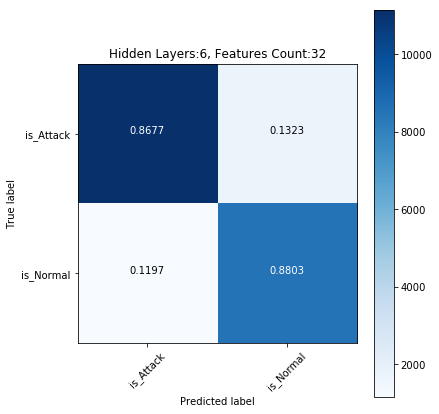

In [16]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)